In [3]:
import numpy as np
import pandas as pd
from textblob import TextBlob

import re
import os

In [4]:
import matplotlib.pyplot as plt
import plotly.express as px

from wordcloud import WordCloud
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = stopwords.words('english')

In [3]:
base_url = 'http://www.imdb.com/title/'

In [6]:
# Getting out data from files
def get_data_dict(comment_dir, url_filename):
    """Takes in location of files and transforms data in to a dictionary."""
    
    data_dict = {}
    
    filenames = []
    for filename in os.listdir(comment_dir):
        f = os.path.join(comment_dir, filename)
        # checking if it is a file
        if os.path.isfile(f):
            filenames.append(f)
    
    # Sorts comment files in order of increasing 'id'. (Check README in data's main directory)
    filenames = sorted(filenames, key = lambda x: int(re.search('[0-9]+',x).group()))
    
    pos = 0
    with open(url_filename) as topo_file:
        for line in topo_file:
            
            #Gets id of each movie from link
            movie_id = re.search('tt[0-9]{7}',line).group()
            current = filenames[pos]

            if movie_id in data_dict:
                # If considering a new rating and comment for an already considered movie 
                
                with open(current, 'r') as file:
                    data = file.read().replace('\n', '')
                    
                #Gets comment/review
                data_dict[movie_id][0].append(data)
                
                #Gets rating for current comment/review
                current_rate = re.search('_[0-9]+',current).group()[1::]
                data_dict[movie_id][1].append(current_rate)


            else:
                data_dict[movie_id] = []

                with open(current, 'r') as file:
                    data = file.read().replace('\n', '')

                data_dict[movie_id].append([data])
                current_rate = re.search('_[0-9]+',current).group()[1::]
                data_dict[movie_id].append([current_rate])
            
            pos+=1

            
    return data_dict

In [7]:
train_pos = get_data_dict('train/pos', 'train/urls_pos.txt')
train_neg = get_data_dict('train/neg', 'train/urls_neg.txt')

In [8]:
test_pos = get_data_dict('test/pos', 'test/urls_pos.txt')
test_neg = get_data_dict('test/neg', 'test/urls_neg.txt')

Function of models to be designed
- One gives you ratings based on vectors of comments
- One gives you key words/phrases that were highlighted that made it positive or negative

In [9]:
def comment_df(dictionary):
    sentiment_rating = pd.DataFrame(columns=['id','comment', 'rating'])
    for id_ in dictionary.keys():
        for cmt,rate in zip(dictionary[id_][0],dictionary[id_][1]):
            sentiment_rating = sentiment_rating.append({'id':id_, 'comment': cmt, 'rating': int(rate)}, ignore_index=True)
            
    return sentiment_rating

In [10]:
train_pos_df = comment_df(train_pos)
train_neg_df = comment_df(train_neg)

In [11]:
test_pos_df = comment_df(test_pos)
test_neg_df = comment_df(test_neg)

In [12]:
train_sentiment = train_pos_df.append(train_neg_df, ignore_index=True)
test_sentiment = test_pos_df.append(test_neg_df, ignore_index=True)

In [13]:
train_sentiment.head()

,id,comment,rating
0,tt0453418,Bromwell High is a cartoon comedy. It ran at t...,9
1,tt0453418,"If you like adult comedy cartoons, like South ...",7
2,tt0453418,Bromwell High is nothing short of brilliant. E...,9
3,tt0064354,"""All the world's a stage and its people actors...",10
4,tt0064354,FUTZ is the only show preserved from the exper...,8


In [14]:
test_sentiment.head()

,id,comment,rating
0,tt0406816,I went and saw this movie last night after bei...,10
1,tt0406816,My boyfriend and I went to watch The Guardian....,10
2,tt0406816,My yardstick for measuring a movie's watch-abi...,7
3,tt0406816,How many movies are there that you can think o...,7
4,tt0406816,This movie was sadly under-promoted but proved...,10


In [15]:
train_sentiment.shape

(25000, 3)

In [16]:
test_sentiment.shape

(25000, 3)

In [18]:
train_sentiment['comment'][3]

'"All the world\'s a stage and its people actors in it"--or something like that. Who the hell said that theatre stopped at the orchestra pit--or even at the theatre door? Why is not the audience participants in the theatrical experience, including the story itself?<br /><br />This film was a grand experiment that said: "Hey! the story is you and it needs more than your attention, it needs your active participation". "Sometimes we bring the story to you, sometimes you have to go to the story."<br /><br />Alas no one listened, but that does not mean it should not have been said.'

## Performing Data Binning to group ratings

In [26]:
bins = [1,4,5,10]
train_sentiment["rating"]

0         9
1         7
2         9
3        10
4         8
         ..
24995     1
24996     1
24997     4
24998     2
24999     2
Name: rating, Length: 25000, dtype: object

In [27]:
group_names = ["negative","neutral","positive"]

In [28]:
train_sentiment["sentiment"] = pd.cut(train_sentiment["rating"],bins,labels=group_names, include_lowest = True)

In [30]:
train_sentiment.nunique()

id            3456
comment      24904
rating           8
sentiment        2
dtype: int64

In [31]:
train_sentiment[['negative','neutral','positive']] = pd.get_dummies(train_sentiment['sentiment']).values

In [33]:
train_sentiment.head()

,id,comment,rating,sentiment,negative,neutral,positive
0,tt0453418,Bromwell High is a cartoon comedy. It ran at t...,9,positive,0,0,1
1,tt0453418,"If you like adult comedy cartoons, like South ...",7,positive,0,0,1
2,tt0453418,Bromwell High is nothing short of brilliant. E...,9,positive,0,0,1
3,tt0064354,"""All the world's a stage and its people actors...",10,positive,0,0,1
4,tt0064354,FUTZ is the only show preserved from the exper...,8,positive,0,0,1


In [34]:
train_sentiment.drop('neutral', axis=1, inplace=True)

In [35]:
train_sentiment.head()

,id,comment,rating,sentiment,negative,positive
0,tt0453418,Bromwell High is a cartoon comedy. It ran at t...,9,positive,0,1
1,tt0453418,"If you like adult comedy cartoons, like South ...",7,positive,0,1
2,tt0453418,Bromwell High is nothing short of brilliant. E...,9,positive,0,1
3,tt0064354,"""All the world's a stage and its people actors...",10,positive,0,1
4,tt0064354,FUTZ is the only show preserved from the exper...,8,positive,0,1


## Visualizing data

<AxesSubplot:>

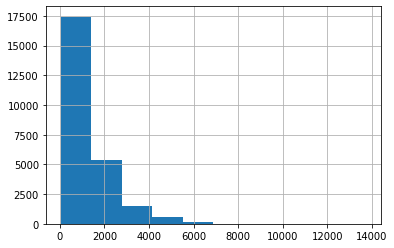

In [36]:
train_sentiment['comment'].str.len().hist()

Most comments/reviews had less than 2000 characters

Text(0, 0.5, 'No. of Comments')

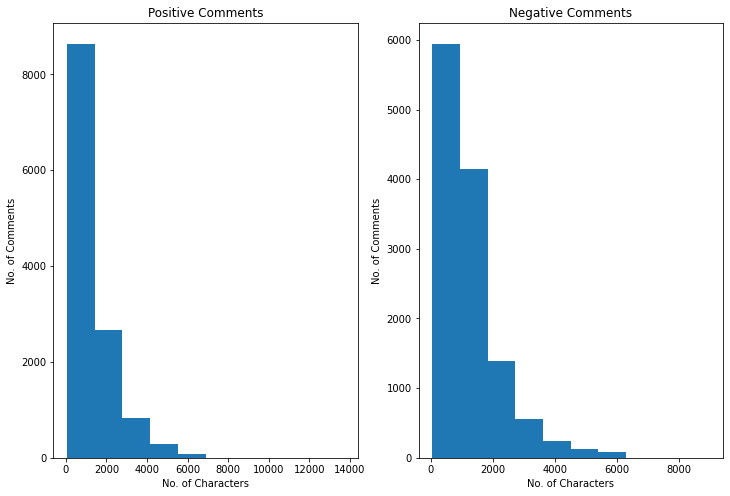

In [38]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
ax1.hist(train_sentiment[train_sentiment['sentiment']=='positive']['comment'].str.len())
ax1.set_title('Positive Comments')
ax2.hist(train_sentiment[train_sentiment['sentiment']=='negative']['comment'].str.len())
ax2.set_title('Negative Comments')



ax1.set_xlabel('No. of Characters')
ax1.set_ylabel('No. of Comments')
ax2.set_xlabel('No. of Characters')
ax2.set_ylabel('No. of Comments')

Negative comments/reviews contain farely more characters than positive

<AxesSubplot:>

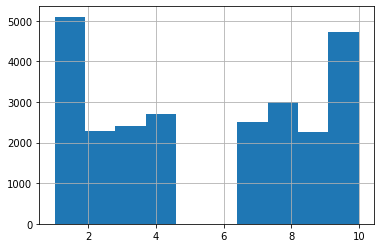

In [40]:
train_sentiment['rating'].hist()

When we had bad ratings, most where completely bad(1), same as when we had good ratings (10)

# Cleaning Data

In [1]:
def clean_comment(comment):        
    # converting to lowercase, removing URL links, special characters, punctuations...
    comment = comment.lower() # converting to lowercase
    comment = re.sub('https?://\S+|www\.\S+', '', comment) # removing URL links
    comment = re.sub(r"\b\d+\b", "", comment) # removing number 
    comment = re.sub('<.*?>+', '', comment) # removing special characters, 
    comment = re.sub('[%s]' % re.escape(string.punctuation), '', comment) # punctuations
    comment = re.sub('\n', '', comment)
    comment = re.sub('[’“”…]', '', comment)
   
    #removing emoji: 
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    comment = emoji_pattern.sub(r'', comment)   

   # removing short form: 
    
    comment=re.sub("isn't",'is not',comment)
    comment=re.sub("he's",'he is',comment)
    comment=re.sub("wasn't",'was not',comment)
    comment=re.sub("there's",'there is',comment)
    comment=re.sub("couldn't",'could not',comment)
    comment=re.sub("won't",'will not',comment)
    comment=re.sub("they're",'they are',comment)
    comment=re.sub("she's",'she is',comment)
    comment=re.sub("There's",'there is',comment)
    comment=re.sub("wouldn't",'would not',comment)
    comment=re.sub("haven't",'have not',comment)
    comment=re.sub("That's",'That is',comment)
    comment=re.sub("you've",'you have',comment)
    comment=re.sub("He's",'He is',comment)
    comment=re.sub("what's",'what is',comment)
    comment=re.sub("weren't",'were not',comment)
    comment=re.sub("we're",'we are',comment)
    comment=re.sub("hasn't",'has not',comment)
    comment=re.sub("you'd",'you would',comment)
    comment=re.sub("shouldn't",'should not',comment)
    comment=re.sub("let's",'let us',comment)
    comment=re.sub("they've",'they have',comment)
    comment=re.sub("You'll",'You will',comment)
    comment=re.sub("i'm",'i am',comment)
    comment=re.sub("we've",'we have',comment)
    comment=re.sub("it's",'it is',comment)
    comment=re.sub("don't",'do not',comment)
    comment=re.sub("that´s",'that is',comment)
    comment=re.sub("I´m",'I am',comment)
    comment=re.sub("it’s",'it is',comment)
    comment=re.sub("she´s",'she is',comment)
    comment=re.sub("he’s'",'he is',comment)
    comment=re.sub('I’m','I am',comment)
    comment=re.sub('I’d','I did',comment)
    comment=re.sub("he’s'",'he is',comment)
    comment=re.sub('there’s','there is',comment)
    
    return comment

In [42]:
train_sentiment['comment'] = train_sentiment['comment'].apply(clean_comment)

In [44]:
train_sentiment.head(10)

,id,comment,rating,sentiment,negative,positive
0,tt0453418,bromwell high is a cartoon comedy it ran at th...,9,positive,0,1
1,tt0453418,if you like adult comedy cartoons like south p...,7,positive,0,1
2,tt0453418,bromwell high is nothing short of brilliant ex...,9,positive,0,1
3,tt0064354,all the worlds a stage and its people actors i...,10,positive,0,1
4,tt0064354,futz is the only show preserved from the exper...,8,positive,0,1
5,tt0100680,i came in in the middle of this film so i had ...,10,positive,0,1
6,tt0100680,fair dramalove story movie that focuses on the...,10,positive,0,1
7,tt0100680,although i didnt like stanley iris tremendous...,7,positive,0,1
8,tt0100680,very good drama although it appeared to have a...,7,positive,0,1
9,tt0100680,workingclass romantic drama from director mart...,7,positive,0,1


Text(0, 0.5, 'No. of Comments')

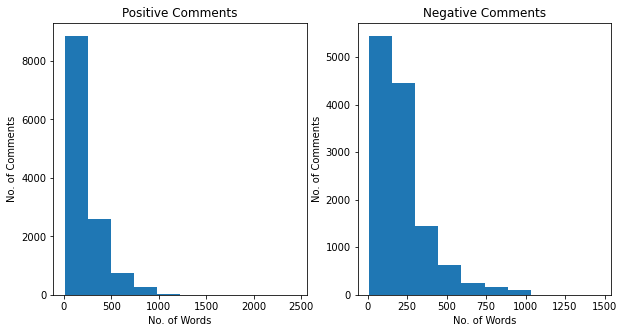

In [54]:
length = pd.DataFrame()
length['len_pos'] = [len(char) for char in train_sentiment[train_sentiment['sentiment']=='positive']['comment'].str.split()]
length['len_neg'] = [len(char) for char in train_sentiment[train_sentiment['sentiment']=='negative']['comment'].str.split()]

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(length['len_pos'])
ax1.set_title('Positive Comments')
ax2.hist(length['len_neg'])
ax2.set_title('Negative Comments')

ax1.set_xlabel('No. of Words')
ax1.set_ylabel('No. of Comments')
ax2.set_xlabel('No. of Words')
ax2.set_ylabel('No. of Comments')

Negative comments/reviews contain fareely more words than positive

In [45]:
train_sentiment.dtypes

id             object
comment        object
rating         object
sentiment    category
negative        uint8
positive        uint8
dtype: object

In [46]:
#Converting values in 'rating' column to integers
train_sentiment.rating = pd.to_numeric(train_sentiment.rating)

In [47]:
train_sentiment.dtypes

id             object
comment        object
rating          int64
sentiment    category
negative        uint8
positive        uint8
dtype: object

# Testing with TextBlob

In [48]:
blob = TextBlob(train_sentiment['comment'][3])
blob.sentiment

Sentiment(polarity=0.20458333333333334, subjectivity=0.5575)

In [49]:
# This was a wrong classification as positive
TextBlob(train_sentiment['comment'][24997]).sentiment.polarity

0.07565789473684209

In [50]:
# Checking accuracy of Textblob classificaion
score = []

for comment in train_sentiment['comment'].values:
    get_score = TextBlob(comment).sentiment.polarity
    if get_score>0:
        score.append(1)
    else:
        score.append(0)

In [125]:
from sklearn.metrics import accuracy_score,classification_report

In [175]:
pd.DataFrame(confusion_matrix(train_sentiment.positive.values, score))

,0,1
0,5365,7135
1,688,11812


In [128]:
accuracy_score(train_sentiment.positive.values, score)

0.68708

In [127]:
print(classification_report(train_sentiment.positive.values, score))

              precision    recall  f1-score   support

           0       0.89      0.43      0.58     12500
           1       0.62      0.94      0.75     12500

    accuracy                           0.69     25000
   macro avg       0.75      0.69      0.66     25000
weighted avg       0.75      0.69      0.66     25000



TextBlob gives a `68.7%` accuracy on the train data

# Further Cleaning of Data

In [55]:
# Removing stop word: 
train_sentiment['no_stopwords'] = train_sentiment['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [56]:
train_sentiment.head()

,id,comment,rating,sentiment,negative,positive,no_stopwords
0,tt0453418,bromwell high is a cartoon comedy it ran at th...,9,positive,0,1,bromwell high cartoon comedy ran time programs...
1,tt0453418,if you like adult comedy cartoons like south p...,7,positive,0,1,like adult comedy cartoons like south park nea...
2,tt0453418,bromwell high is nothing short of brilliant ex...,9,positive,0,1,bromwell high nothing short brilliant expertly...
3,tt0064354,all the worlds a stage and its people actors i...,10,positive,0,1,worlds stage people actors itor something like...
4,tt0064354,futz is the only show preserved from the exper...,8,positive,0,1,futz show preserved experimental theatre movem...


In [57]:
# Getting the most Frequent Words: 
from collections import Counter
word_freq = Counter()
for text in train_sentiment["no_stopwords"].values:
    for word in text.split():
        word_freq[word] += 1
word_freq.most_common(10)
top_10 = pd.DataFrame(word_freq.most_common(10))
top_10.columns=['word', 'count']
top_10

,word,count
0,movie,41825
1,film,37486
2,one,25165
3,like,19567
4,good,14516
5,even,12326
6,would,12124
7,time,11807
8,really,11642
9,story,11438


In [64]:
Lemmatizer = WordNetLemmatizer()

In [104]:
# Removing Top frequent words that don't contribute to sentiment
# Performing Lemmatization

def complete_clean(df):
        
    # Getting the most Frequent Words:
    from collections import Counter
    word_freq = Counter()
    for text in df["no_stopwords"].values:
        for word in text.split():
            word_freq[word] += 1
    word_freq.most_common(10)
    top_10 = pd.DataFrame(word_freq.most_common(10))
    top_10.columns=['word', 'count']
    top_10
    
    top10_words = top_10['word'].values
    df["no_stop_freq"] = df["no_stopwords"].apply(lambda x: " ".join([word for word in str(x).split() if word not in top10_words]))
        
    df['no_stop_freq_lem'] = df['no_stop_freq'].apply(Lemmatizer.lemmatize)
    
    return df

In [105]:
train_sentiment = complete_clean(train_sentiment)
train_sentiment.head()

,id,comment,rating,sentiment,negative,positive,no_stopwords,no_stop_freq,no_stop_freq_lem
0,tt0453418,bromwell high is a cartoon comedy it ran at th...,9,positive,0,1,bromwell high cartoon comedy ran time programs...,bromwell high cartoon comedy ran programs scho...,bromwell high cartoon comedy ran programs scho...
1,tt0453418,if you like adult comedy cartoons like south p...,7,positive,0,1,like adult comedy cartoons like south park nea...,adult comedy cartoons south park nearly simila...,adult comedy cartoons south park nearly simila...
2,tt0453418,bromwell high is nothing short of brilliant ex...,9,positive,0,1,bromwell high nothing short brilliant expertly...,bromwell high nothing short brilliant expertly...,bromwell high nothing short brilliant expertly...
3,tt0064354,all the worlds a stage and its people actors i...,10,positive,0,1,worlds stage people actors itor something like...,worlds stage people actors itor something hell...,worlds stage people actors itor something hell...
4,tt0064354,futz is the only show preserved from the exper...,8,positive,0,1,futz show preserved experimental theatre movem...,futz show preserved experimental theatre movem...,futz show preserved experimental theatre movem...


In [106]:
train_sentiment['comment'][1]

'if you like adult comedy cartoons like south park then this is nearly a similar format about the small adventures of three teenage girls at bromwell high keisha natella and latrina have given exploding sweets and behaved like bitches i think keisha is a good leader there are also small stories going on with the teachers of the school theres the idiotic principal mr bip the nervous maths teacher and many others the cast is also fantastic lenny henrys gina yashere eastenders chrissie watts tracyann oberman smack the ponys doon mackichan dead ringers mark perry and blunders nina conti i didnt know this came from canada but it is very good very good'

In [107]:
train_sentiment['no_stopwords'][1]

'like adult comedy cartoons like south park nearly similar format small adventures three teenage girls bromwell high keisha natella latrina given exploding sweets behaved like bitches think keisha good leader also small stories going teachers school theres idiotic principal mr bip nervous maths teacher many others cast also fantastic lenny henrys gina yashere eastenders chrissie watts tracyann oberman smack ponys doon mackichan dead ringers mark perry blunders nina conti didnt know came canada good good'

In [108]:
train_sentiment['no_stop_freq'][1]

'adult comedy cartoons south park nearly similar format small adventures three teenage girls bromwell high keisha natella latrina given exploding sweets behaved bitches think keisha leader also small stories going teachers school theres idiotic principal mr bip nervous maths teacher many others cast also fantastic lenny henrys gina yashere eastenders chrissie watts tracyann oberman smack ponys doon mackichan dead ringers mark perry blunders nina conti didnt know came canada'

In [109]:
train_sentiment['no_stop_freq_lem'][1]

'adult comedy cartoons south park nearly similar format small adventures three teenage girls bromwell high keisha natella latrina given exploding sweets behaved bitches think keisha leader also small stories going teachers school theres idiotic principal mr bip nervous maths teacher many others cast also fantastic lenny henrys gina yashere eastenders chrissie watts tracyann oberman smack ponys doon mackichan dead ringers mark perry blunders nina conti didnt know came canada'

# Modelling

## Testing with TextBlob on Further cleaned data

In [110]:
score1 = []

for comment in train_sentiment['comment'].values:
    get_score = TextBlob(comment).sentiment.polarity
    if get_score>0:
        score1.append(1)
    else:
        score1.append(0)

accuracy_score(train_sentiment.positive.values, score1)

0.68708

In [111]:
score2 = []

for comment in train_sentiment['no_stopwords'].values:
    get_score = TextBlob(comment).sentiment.polarity
    if get_score>0:
        score2.append(1)
    else:
        score2.append(0)

accuracy_score(train_sentiment.positive.values, score2)

0.69776

In [112]:
score3 = []

for comment in train_sentiment['no_stop_freq'].values:
    get_score = TextBlob(comment).sentiment.polarity
    if get_score>0:
        score3.append(1)
    else:
        score3.append(0)

accuracy_score(train_sentiment.positive.values, score3)

0.72212

In [113]:
# Checking accuracy of Textblob classificaion
score4 = []

for comment in train_sentiment['no_stop_freq_lem'].values:
    get_score = TextBlob(comment).sentiment.polarity
    if get_score>0:
        score4.append(1)
    else:
        score4.append(0)

accuracy_score(train_sentiment.positive.values, score4)

0.72212

### Textblob performed best after Lemmatization
Accuracy: `72.212%`

# Preparing Test Data

In [114]:
test_sentiment.head()

,id,comment,rating,sentiment,negative,positive,no_stopwords,no_stop_freq,no_stop_freq_lem
0,tt0406816,i went and saw this movie last night after bei...,10,positive,0,1,went saw movie last night coaxed friends mine ...,i went to the as a sneak preview in austria so...,i went to the as a sneak preview in austria so...
1,tt0406816,my boyfriend and i went to watch the guardiana...,10,positive,0,1,boyfriend went watch guardianat first didnt wa...,i went to the as a sneak preview in austria so...,i went to the as a sneak preview in austria so...
2,tt0406816,my yardstick for measuring a movies watchabili...,7,positive,0,1,yardstick measuring movies watchability get sq...,i went to the as a sneak preview in austria so...,i went to the as a sneak preview in austria so...
3,tt0406816,how many movies are there that you can think o...,7,positive,0,1,many movies think see movie like cant count su...,i went to the as a sneak preview in austria so...,i went to the as a sneak preview in austria so...
4,tt0406816,this movie was sadly underpromoted but proved ...,10,positive,0,1,movie sadly underpromoted proved truly excepti...,i went to the as a sneak preview in austria so...,i went to the as a sneak preview in austria so...


In [115]:
test_sentiment["sentiment"] = pd.cut(test_sentiment["rating"],bins,labels=group_names, include_lowest = True)

In [116]:
test_sentiment[['negative','neutral','positive']] = pd.get_dummies(test_sentiment['sentiment']).values

In [117]:
test_sentiment.drop('neutral', axis=1, inplace=True)

In [143]:
test_sentiment.head()

,id,comment,rating,sentiment,negative,positive,no_stopwords,no_stop_freq,no_stop_freq_lem
0,tt0406816,i went and saw this movie last night after bei...,10,positive,0,1,went saw movie last night coaxed friends mine ...,went saw last night coaxed friends mine ill ad...,went saw last night coaxed friends mine ill ad...
1,tt0406816,my boyfriend and i went to watch the guardiana...,10,positive,0,1,boyfriend went watch guardianat first didnt wa...,boyfriend went watch guardianat first didnt wa...,boyfriend went watch guardianat first didnt wa...
2,tt0406816,my yardstick for measuring a movies watchabili...,7,positive,0,1,yardstick measuring movies watchability get sq...,yardstick measuring movies watchability get sq...,yardstick measuring movies watchability get sq...
3,tt0406816,how many movies are there that you can think o...,7,positive,0,1,many movies think see movie like cant count su...,many movies think cant count sure seemed maker...,many movies think cant count sure seemed maker...
4,tt0406816,this movie was sadly underpromoted but proved ...,10,positive,0,1,movie sadly underpromoted proved truly excepti...,sadly underpromoted proved truly exceptional e...,sadly underpromoted proved truly exceptional e...


In [119]:
test_sentiment['comment'] = test_sentiment['comment'].apply(clean_comment)

In [120]:
#Converting values in 'rating' column to integers
test_sentiment.rating = pd.to_numeric(test_sentiment.rating)

In [121]:
# Removing stop word: 
test_sentiment['no_stopwords'] = test_sentiment['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [122]:
test_sentiment = complete_clean(test_sentiment)

In [123]:
test_sentiment.head()

,id,comment,rating,sentiment,negative,positive,no_stopwords,no_stop_freq,no_stop_freq_lem
0,tt0406816,i went and saw this movie last night after bei...,10,positive,0,1,went saw movie last night coaxed friends mine ...,went saw last night coaxed friends mine ill ad...,went saw last night coaxed friends mine ill ad...
1,tt0406816,my boyfriend and i went to watch the guardiana...,10,positive,0,1,boyfriend went watch guardianat first didnt wa...,boyfriend went watch guardianat first didnt wa...,boyfriend went watch guardianat first didnt wa...
2,tt0406816,my yardstick for measuring a movies watchabili...,7,positive,0,1,yardstick measuring movies watchability get sq...,yardstick measuring movies watchability get sq...,yardstick measuring movies watchability get sq...
3,tt0406816,how many movies are there that you can think o...,7,positive,0,1,many movies think see movie like cant count su...,many movies think cant count sure seemed maker...,many movies think cant count sure seemed maker...
4,tt0406816,this movie was sadly underpromoted but proved ...,10,positive,0,1,movie sadly underpromoted proved truly excepti...,sadly underpromoted proved truly exceptional e...,sadly underpromoted proved truly exceptional e...


# TfidfVectorizer and Naive Bayes

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.pipeline import make_pipeline

In [145]:
models = [MultinomialNB, ComplementNB, BernoulliNB]
ngram_ranges=[(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)]
comments = ['comment','no_stopwords','no_stop_freq','no_stop_freq_lem']

In [178]:
for model in models:
    pattern = r'.[a-zA-Z]+NB'
    match = re.search(pattern, str(model))
    for ngram in ngram_ranges:
        main_model = make_pipeline(TfidfVectorizer(ngram_range=ngram), model())
        for comment in comments:
            main_model.fit(train_sentiment[comment], train_sentiment.positive)
            predictions = main_model.predict(test_sentiment[comment])
            
            print(f"Validation report of \n{match.group()[1::]}, ngram_range: {ngram}, data: {comment}")
            print('-'*45)
            print('Confusion Matrix')
            print(pd.crosstab(test_sentiment.positive.values, predictions, rownames=['Actual Category'], colnames=['Predicted Category']))
            print('-'*45)
            print(classification_report(test_sentiment.positive.values, predictions))
            print()
            print()

Validation report of 
MultinomialNB, ngram_range: (1, 1), data: comment
---------------------------------------------
Confusion Matrix
Predicted Category      0     1
Actual Category                
0                   11114  1386
1                    2848  9652
---------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.89      0.84     12500
           1       0.87      0.77      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.84      0.83      0.83     25000
weighted avg       0.84      0.83      0.83     25000



Validation report of 
MultinomialNB, ngram_range: (1, 1), data: no_stopwords
---------------------------------------------
Confusion Matrix
Predicted Category      0     1
Actual Category                
0                   10975  1525
1                    2604  9896
---------------------------------------------
              precision    recall  f1-score   su

Validation report of 
MultinomialNB, ngram_range: (2, 2), data: no_stopwords
---------------------------------------------
Confusion Matrix
Predicted Category      0      1
Actual Category                 
0                   11269   1231
1                    2484  10016
---------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.90      0.86     12500
           1       0.89      0.80      0.84     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



Validation report of 
MultinomialNB, ngram_range: (2, 2), data: no_stop_freq
---------------------------------------------
Confusion Matrix
Predicted Category      0     1
Actual Category                
0                   11079  1421
1                    2539  9961
---------------------------------------------
              precision    recall  f1-s

Validation report of 
ComplementNB, ngram_range: (1, 1), data: no_stop_freq
---------------------------------------------
Confusion Matrix
Predicted Category      0     1
Actual Category                
0                   10959  1541
1                    2544  9956
---------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.88      0.84     12500
           1       0.87      0.80      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



Validation report of 
ComplementNB, ngram_range: (1, 1), data: no_stop_freq_lem
---------------------------------------------
Confusion Matrix
Predicted Category      0     1
Actual Category                
0                   10959  1541
1                    2544  9956
---------------------------------------------
              precision    recall  f1-sco

Validation report of 
ComplementNB, ngram_range: (2, 2), data: no_stop_freq_lem
---------------------------------------------
Confusion Matrix
Predicted Category      0     1
Actual Category                
0                   11079  1421
1                    2539  9961
---------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.89      0.85     12500
           1       0.88      0.80      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



Validation report of 
ComplementNB, ngram_range: (2, 3), data: comment
---------------------------------------------
Confusion Matrix
Predicted Category      0      1
Actual Category                 
0                   11347   1153
1                    1805  10695
---------------------------------------------
              precision    recall  f1-scor

Validation report of 
BernoulliNB, ngram_range: (1, 2), data: comment
---------------------------------------------
Confusion Matrix
Predicted Category      0     1
Actual Category                
0                   11482  1018
1                    2771  9729
---------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.92      0.86     12500
           1       0.91      0.78      0.84     12500

    accuracy                           0.85     25000
   macro avg       0.86      0.85      0.85     25000
weighted avg       0.86      0.85      0.85     25000



Validation report of 
BernoulliNB, ngram_range: (1, 2), data: no_stopwords
---------------------------------------------
Confusion Matrix
Predicted Category      0     1
Actual Category                
0                   11661   839
1                    3458  9042
---------------------------------------------
              precision    recall  f1-score   suppor

Validation report of 
BernoulliNB, ngram_range: (2, 3), data: no_stopwords
---------------------------------------------
Confusion Matrix
Predicted Category      0     1
Actual Category                
0                   12227   273
1                    6361  6139
---------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.98      0.79     12500
           1       0.96      0.49      0.65     12500

    accuracy                           0.73     25000
   macro avg       0.81      0.73      0.72     25000
weighted avg       0.81      0.73      0.72     25000



Validation report of 
BernoulliNB, ngram_range: (2, 3), data: no_stop_freq
---------------------------------------------
Confusion Matrix
Predicted Category      0     1
Actual Category                
0                   12319   181
1                    8127  4373
---------------------------------------------
              precision    recall  f1-score   s

Best Models
- ComplementNB, ngram_range: (2, 3), data: comment - Key ~ 88%
- ComplementNB, ngram_range: (2, 2), data: comment
- ComplementNB, ngram_range: (1, 3), data: comment


- MultinomialNB, ngram_range: (2, 3), data: comment - Key ~ 88%
- MultinomialNB, ngram_range: (2, 2), data: comment
- MultinomialNB, ngram_range: (1, 3), data: comment

Best Negative Sentiment Prediction Models ~100%
- BernoulliNB, ngram_range: (3, 3), data: no_stop_freq
- BernoulliNB, ngram_range: (3, 3), data: no_stop_freq_lem

Best Positive Sentiment Prediction Models ~86%
- ComplementNB, ngram_range: (2, 3), data: comment
- MultinomialNB, ngram_range: (2, 3), data: comment

In [49]:
train_sentiment.to_csv('train-sentiment.csv', index=False)
test_sentiment.to_csv('test-sentiment.csv', index=False)